El primer módulo del programa se encarga de llamar el conjunto de Bibliotecas (librerias) que serán utlizadas en el proceso de desarrollo del programa. 

Se argegó un punto en donde se puede modificar el nombre del país de sur américa que necesitamos analizar.

In [1]:
PAIS='Argentina'

In [2]:
#****************************************************************************************************************************************
#Programa: Gaussian_Processes_Time_Series_II.ipynb                                                                                      *
#Lenguaje: Python en ambiente Google Colab                                                                                              *
#Utilidad: Uso de Gaussian Processes (Proceso Gaussiano) y Cadenas de Markov con Simulaciones de Montecarlo. (MCMC) para el modelado de *
#Series de tiempo.                                                                                                                      *
#Realizado por: Instituto Salud Global de la Universidad Argentina John F. Kennedy.                                                     *
#Programadores: Ernesto Freiberg y Alvin Correa                                                                                           *
#Observaciones: El presente  modelo es una variante de inferencia bayesiana aplicada a las series de tiempo. El modelo de proceso       *
#Gaussiano  utiliza una distribución a priori que en nuestro caso es una distribución Gamma para la componente regular y una normal para*
#la tendencia.                                                                                                                          *
#****************************************************************************************************************************************
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
import jax.tools.colab_tpu
import pymc.sampling_jax
import matplotlib.pyplot as plt
from jax.lib import xla_bridge
from sklearn import linear_model

In [3]:
is_tpu_platform = xla_bridge.get_backend().platform == 'tpu'

if is_tpu_platform: 
  jax.tools.colab_tpu.setup_tpu()

In [4]:
paises = pd.read_excel('https://github.com/saludglobaluk/colorectal_cancel_mortality_south_america/blob/main/data/Index.xlsx?raw=true')
print('Paises disponibles:')
paises.PAIS

Paises disponibles:


0     Argentina
1       Bolivia
2        Brasil
3         Chile
4      Colombia
5       Ecuador
6      Paraguay
7          Peru
8         Total
9       Uruguay
10    Venezuela
Name: PAIS, dtype: object

In [5]:
def import_excel(pais):
  of = pd.read_excel(paises.loc[paises['PAIS'] == pais, 'DATOS'].values[0])
  of.columns = ['year','deaths']
  of[['year', 'deaths']] = of[['year', 'deaths']].astype(int)
  return of

El siguiente módulo se encarga de subir el archivo de con los datos de las defunciones por año y pais.

In [6]:
print(PAIS)
of = import_excel(PAIS)
df = of.copy()

Argentina


Se construye la grafica de la serie de tiempo. y se agrega una linea de tendencia. 

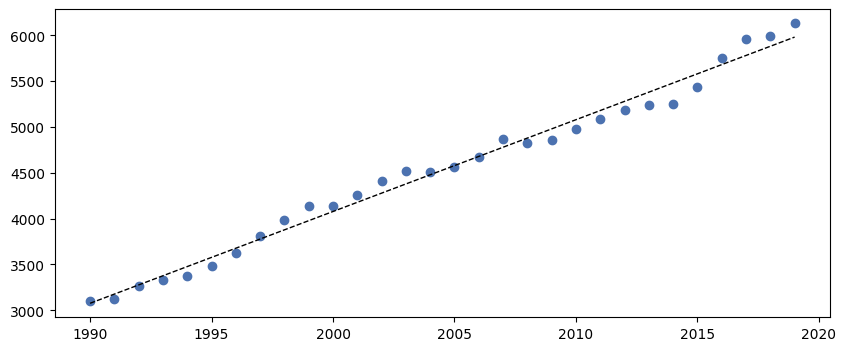

In [7]:
sns.set_palette(palette='deep')

x = np.array(df.year).reshape((-1, 1))
y = df.deaths
linear = linear_model.LinearRegression().fit(x, y)
y_pred = linear.predict(x)

plt.figure(figsize=(10, 4))
plt.scatter(x, y)
plt.plot(x, y_pred, color='black', linewidth=1, linestyle='dashed')
plt.show()

Establece el año base
El tamaño de la muestra, es decir, la cantidad de años. 
establece la cantidad de años a proyectar hacia el futuro.(2030)

In [ ]:
year_base = df.year.min()
year_at_0 = (df.year - year_base).values
year_at_0_future = np.arange(year_at_0.max(), year_at_0.max() + 11, 1)
deaths = df.deaths.to_numpy()

Esta rutina primero se encarga de construir los hiper parametros de la distribución a priori. Dichos hiperparametros, son generados mediante dos distribuciones Gamma, con parametros (120,1) y (120,1) respectivamente. 
Luego, se genera el componente regular de la serie de tiempo utilizando una la distribución normal. Esto es la primera parte del Prior.
Luego se genera el componente de tendencia, mediante una normal con media mu=0  varianza = 4. Se asigna una tendencia lineal a traves de la matriz de varianza y covarianza. Se suman las dos componentes que conforman el Prior para luego generar el Likehood utilizando los datos de las defunciones y agregando un ruido blanco para mantener la aleatoriadad

In [ ]:
with pm.Model() as model:
  ls_1 = pm.Gamma(name='ls_1', alpha=120, beta=1)
  period_1 = pm.Gamma(name='period_1', alpha=120, beta=1)
  cov_1 = period_1**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_1)
  gp_1 = pm.gp.Marginal(cov_func=cov_1)
  
  c_3 = pm.Normal(name='c_3', mu=0, sigma=4)
  cov_3 = pm.gp.cov.Linear(input_dim=1, c=c_3)
  gp_3 = pm.gp.Marginal(cov_func=cov_3)
    
  gp = gp_1 + gp_3

  sigma = pm.HalfNormal(name='sigma', sigma=10)

  y_pred = gp.marginal_likelihood('y_pred', X=year_at_0.reshape(30, 1), y=deaths, noise=sigma)


Ejecuta el proceso de Cadenas de Markov con simulaciones de montecarlo. (MCMC) se agregan 3000 iteraciones y 1500 de tunning o refinamiento. 

In [ ]:
with model:
  if is_tpu_platform:
    trace = pm.sampling_jax.sample_numpyro_nuts(5000, tune=2000)
  else:
    trace = pm.sample(3000, tune=1500)

Este proceso se encarga de hacer un refinamiento o ajuste del modelo para lograr una mayor acuracidad y presicion en el mismo. 

In [ ]:
with model:    
  x_train_conditional = gp.conditional('x_train_conditional', year_at_0.reshape(30, 1), pred_noise=True)
  y_train_pred_samples = pm.sample_posterior_predictive(trace, var_names=['x_train_conditional'])

  x_test_conditional = gp.conditional('x_test_conditional', year_at_0_future.reshape(11, 1), pred_noise=True)
  y_test_pred_samples = pm.sample_posterior_predictive(trace, var_names=['x_test_conditional'])

Se generan los graficos de las distribuciones y de los ruidos blanco. 

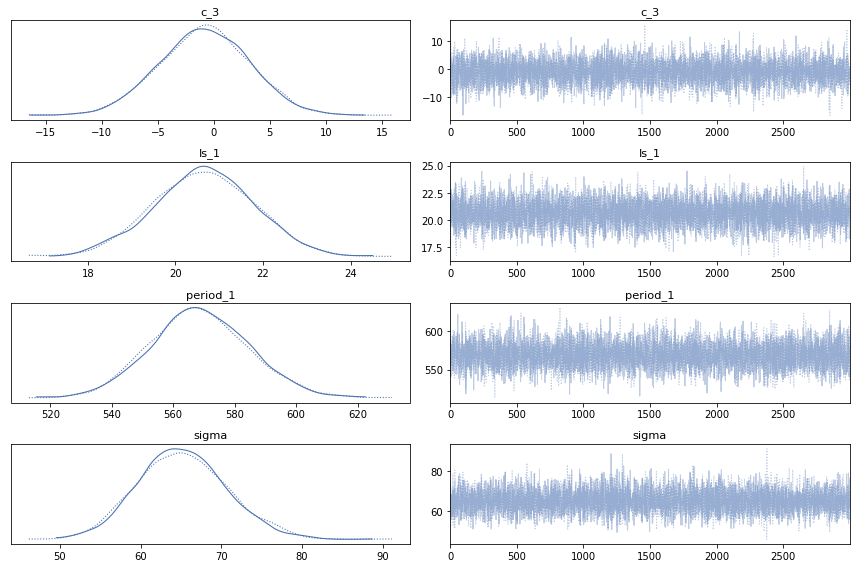

In [ ]:
pm.plot_trace(trace)
plt.tight_layout()
plt.show()

Se genera un resumen de las medidas descriptivas de la salida del modelo.

In [ ]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c_3,-0.841,4.039,-8.012,6.928,0.046,0.047,7607.0,4297.0,1.0
ls_1,20.656,1.150,18.398,22.697,0.012,0.009,8502.0,4839.0,1.0
period_1,568.734,15.989,538.580,598.488,0.167,0.118,9136.0,5091.0,1.0
sigma,65.195,5.492,55.353,75.883,0.056,0.040,9629.0,4939.0,1.0


Se utiliza la distribucion posterior (a posteriori) o "posterior", para generar las estimaciones a 2030 de las defunciones.

In [ ]:
y_train_pred_samples_mean = y_train_pred_samples.posterior_predictive.x_train_conditional.mean(axis=0)
y_train_pred_samples_std = y_train_pred_samples.posterior_predictive.x_train_conditional.std(axis=0)
y_train_pred_samples_mean_plus = y_train_pred_samples_mean + 2*y_train_pred_samples_std
y_train_pred_samples_mean_minus = y_train_pred_samples_mean - 2*y_train_pred_samples_std

y_test_pred_samples_mean = y_test_pred_samples.posterior_predictive.x_test_conditional.mean(axis=0)
y_test_pred_samples_std = y_test_pred_samples.posterior_predictive.x_test_conditional.std(axis=0)
y_test_pred_samples_mean_plus = y_test_pred_samples_mean + 2*y_test_pred_samples_std
y_test_pred_samples_mean_minus = y_test_pred_samples_mean - 2*y_test_pred_samples_std

Se genera el grafico con la simulacion de los escenarios generados de manera aleatoria con las simulaciones de montecarlo. La presente grafica se insterpreta según la intensidad de los colores en los mismos, es decir, a mayor intensidad de color podemos encontrar una menor variabilidad y en caso inverso podemos observar una mayor presencia de ruido en las estimaciones. 

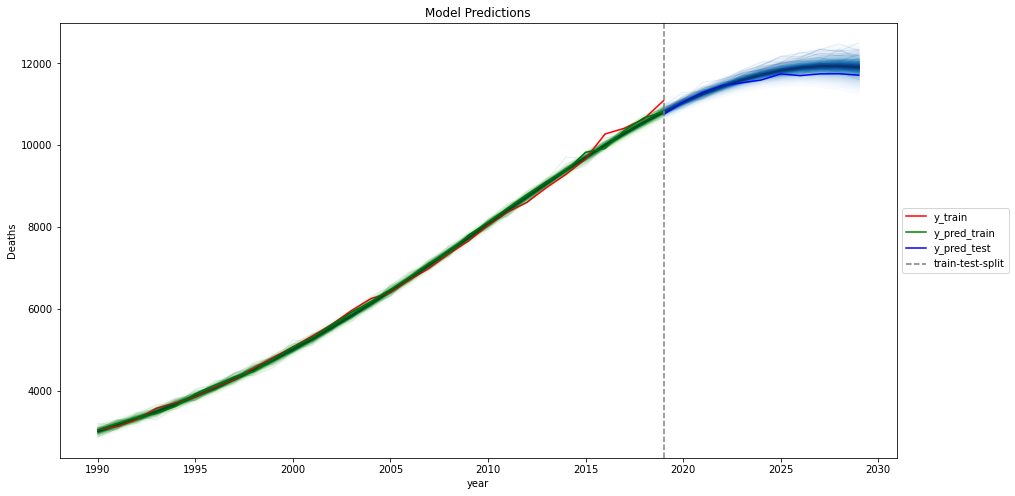

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x=year_base + year_at_0, y=deaths, color='red', label='y_train', ax=ax)

sns.lineplot(x=year_base + year_at_0, y=y_train_pred_samples_mean[0,:], color='green', label='y_pred_train', ax=ax)

sns.lineplot(x=year_base + year_at_0_future, y=y_test_pred_samples_mean[0,:], color='blue', label='y_pred_test', ax=ax)

pm.gp.util.plot_gp_dist(ax, y_train_pred_samples.posterior_predictive.x_train_conditional[0,:], 
                        year_base + year_at_0, palette="Greens")

pm.gp.util.plot_gp_dist(ax, y_test_pred_samples.posterior_predictive.x_test_conditional[0,:], 
                        year_base + year_at_0_future, palette="Blues")

ax.axvline(x=year_base + year_at_0[-1], color='gray', linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Model Predictions', xlabel='year', ylabel='Deaths');

Cifras estimadas de las defunciones por cáncer de cólon hasta 2029

In [ ]:
#La idea de este bloque es generar las cifras de las estimaciones que aparecen en color azul en la grafica... es decir, un escenarios de todos los
# posibles mostrados en la grafica.

ds = pd.DataFrame(data={
  'years': year_base + year_at_0_future, 
  'deaths': y_test_pred_samples_mean[0,:].to_numpy().astype(int),
  'lim-inf': y_test_pred_samples_mean_minus[0,:].to_numpy().astype(int),
  'lim-sup': y_test_pred_samples_mean_plus[0,:].to_numpy().astype(int),
  })

ds

,years,deaths,lim-inf,lim-sup
0,2019,10750,10720,10780
1,2020,11051,10976,11127
2,2021,11288,11242,11333
3,2022,11456,11316,11595
4,2023,11522,11387,11657
5,2024,11591,11525,11658
6,2025,11740,11476,12005
7,2026,11699,11455,11942
8,2027,11741,11575,11907
9,2028,11745,11462,12027


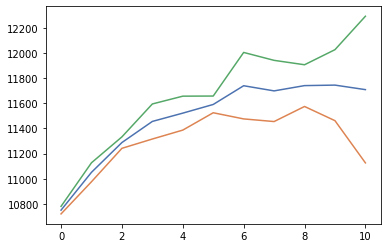

In [ ]:
plt.plot(ds.deaths)
plt.plot(ds['lim-inf'])
plt.plot(ds['lim-sup'])
plt.show()